# Test Data-Science Iktos 

## Table of contents
[Preliminary question](#prel)

I [Chapter 1 : Descriptives statistics](#chap1)    
- [Section 1.1 Plot molecules features mean vector ](#hist)   
- [Section 1.2 Principal Components Analysis (PCA).](#pca1)    
- [Section 1.3 PCA most explicatives components](#pca2)    

II [Chapter 2 : Modelling](#mod)
- [Section 2.1 Predictive model building](#train)
  - [Section 2.1.1 Morgan Fingerprint function and Custom transformer class](#morgan)
  - [Section 2.1.2 Data processing pipeline](#pipeline)
  - [Section 2.1.3 Hyperparameters optimization](#hyper)
- [Section 2.2 Activity prediction on the test set](#test)


#### Import librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Rdkit packages
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import AllChem
#!pip install joblib
#!pip install pubchempy
#!pip install pycaret
import pycaret
import joblib
#!pip install sklearn
# sklearn and imblearn packages
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, make_scorer, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from scikitplot.decomposition import plot_pca_component_variance
from xgboost import XGBClassifier
import xgboost
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
# Beware to import Pipeline from imblearn package and not the one from sklearn which is different
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import ADASYN

### Preliminary question <a class="anchor" id="prel"></a>

#### Build a vector description of molecules using the fingerprint RDKIT "MACCSkeys"(https://www.rdkit.org/docs/GettingStartedInPython.html). Check that the matrix of features obtained is of dimension (300,167).

Change the working directory

In [2]:
cd D:\\DSTI\\test_data_science_internship

D:\DSTI\test_data_science_internship


In [3]:
# Import des datasets train et test
train = pd.read_csv("train_set_data.csv")
test = pd.read_csv("test_set_data.csv")

In [4]:
# Display the first rows of the train dataframe and increase the size to see the whole SMILES data
train_head = train.head()
train_head.style.set_table_attributes('style="font-size: 17px"')

,SMILES,Activity
0,CCNC(=O)C1OC(n2cnc3c(N)nc(CCCC4CCN(C(=O)Oc5ccc(NO)cc5)CC4)nc32)C(O)C1O,1
1,COc1ccc(CC(=O)Nc2nc(SC)nc3nc(-c4ccco4)nn23)cc1,0
2,CC(=O)COc1ccc(N2CCN(CCn3ncc4c3nc(N)n3nc(-c5ccco5)nc43)CC2)cc1,1
3,Nc1nc(-c2ccco2)c2nnn(Cc3ccc4[nH]ncc4c3)c2n1,1
4,Nc1nc(CN2CCN(Cc3cc4ccccc4o3)CC2)nc2nc(-c3ccco3)nn12,0


In [5]:
# Check the number of molecules inside the train dataset
print(f"The train dataset contains {len(train)} molecules")

The train dataset contains 300 molecules


In [6]:
# Check the number of molecules inside the test dataset
print(f"The test dataset contains {len(test)} molecules")

The test dataset contains 8368 molecules


The **test** dataset is actually **bigger** than the **train** dataset. Generally the test dataset is smaller than the train dataset. We have also to **consider the balance of the target variable "Activity"** as this has the consequence on the  **validity of prediction.**

We will get the molecule from the SMILES information contained in the dataset thanks to the MolFromSmiles method

We build a list extracting molecules information for the train dataset's set of molecules 

In [7]:
# ms is a list containing the molecules in the train set
ms = [Chem.MolFromSmiles(x) for x in train.SMILES]

We can then extract binary fingerprint thanks to the MACCS key from the molecule information (creating first an **rdkit object**). Each bit position represents the presence (=1) or absence(=0) of a defined structural feature (166 keys in total).

In [8]:
# fps object contains the MACCSkeys information
from rdkit.Chem import MACCSkeys
fps = [MACCSkeys.GenMACCSKeys(x) for x in ms]

We transform the fps object into a numpy array and check that the final shape of the matrix is (300,167)

In [9]:
# mat_mol_binary object is the numpy array of the fps object
mat_mol_binary = np.array(fps)
print(mat_mol_binary.shape)

(300, 167)


## Chapter 1 : Descriptives statistics <a class="anchor" id="chap1"></a>

### Section 1.1 Plot features mean vector <a class="anchor" id="hist"></a>

We then compute the average of the features (of size 167) for each molecule

In [10]:
mat_molecules_sum = np.mean(mat_mol_binary, axis = 1,dtype = np.float64) #float64 increase precision

### Univariate plot of average of MACCSkeys features for each molecule

Text(0.5, 1.0, 'Histogram of MACCSkeys features averaged for each molecule')

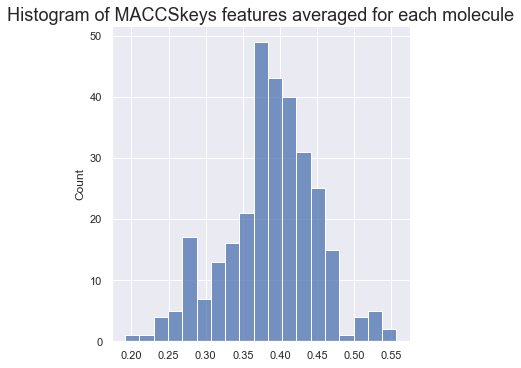

In [11]:
# Apply the default theme
sns.set_theme()
sns.displot(mat_molecules_sum)
plt.title("Histogram of MACCSkeys features averaged for each molecule", fontsize=18)

We will improve a bit the histogramm by discretize the histogramm by modifying the discretization

Text(0.5, 1.0, 'Histogram of MACCSkeys features averaged for each molecule (after bin discretization)')

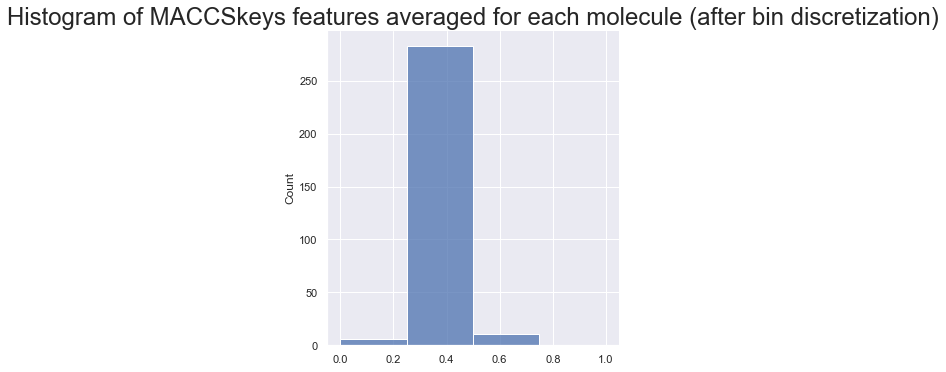

In [12]:
ax = sns.displot(mat_molecules_sum,bins=[0, 0.25, 0.5, 0.75, 1], palette="Accent")
plt.title("Histogram of MACCSkeys features averaged for each molecule (after bin discretization)", fontsize=24)

We notice that the main part of the molecules has an average between 0.25 and 0.5

Before going to data pre-processing let's check the distribution of the target variable in the train dataset and in the final test set

In [13]:
# Check frequency of the target variable in the train dataset
def plot_cat(data,target):
    fig = ((data[target].value_counts())/len(data)).plot.bar()
    # Rotate the labels and set a title to the plot
    plt.xticks(rotation = 360)
    plt.title("Frequency of the distribution of the target variable (Activity)", fontsize = 22)
    return fig

<AxesSubplot:title={'center':'Frequency of the distribution of the target variable (Activity)'}>

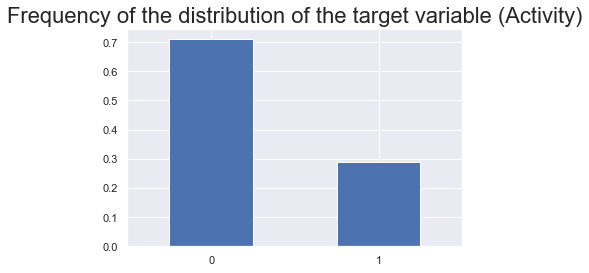

In [14]:
# Call the plot_cat function
plot_cat(train,'Activity')

So the **training set is not balanced** ! They are much more molecules presenting no activity (**Activity = 0**) around **70%** of the dataset !
We have to consider this observation later for modelling especially for the metric choice.

### Section 1.2 Principal Components Analysis (PCA)<a class="anchor" id="pca1"></a>

To summarize the set of the features. We will apply a Principal Components Analysis to the 167 binary-features we created just before.

In [15]:
# Creation of a pca object then apply it to the set of molecules
pca = PCA()
X_train = pca.fit_transform(mat_mol_binary)
#X_test = pca.transform(test)

Let's plot the explained variance ratio with the number of components 

In [16]:
# Use a fonction to plot the explained variance ratio
def plot_pca_expl(mol_matrix):
    """From a matrix containing molecule information plot the explained variance ratio (using PCA)"""
    pca = PCA()
    X_train = pca.fit_transform(mol_matrix)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.title("Cumulative explained variance ratio using MACCSkeys features (167 features) in the train set", fontsize = 18);

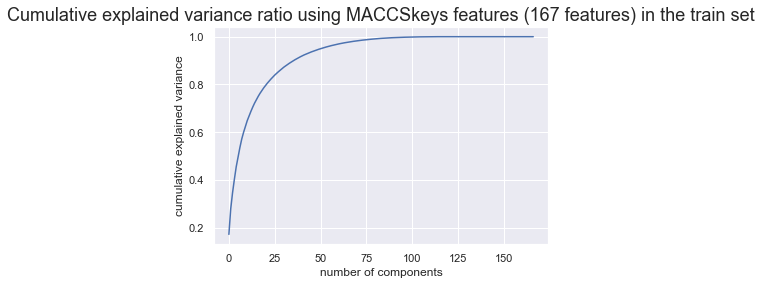

In [17]:
# Call the function plot_pca_expl
plot_pca_expl(mat_mol_binary)

We can see from this plot that a **PCA** of **less than 50 components** retains more than **90% of the explained variance** 

In [18]:
# Apply a pca using 2 components to the set of molecules
pca = PCA(n_components = 2)
X_reduced = pca.fit_transform(mat_mol_binary)
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [19]:
# Create a dataframe containing the 2 principal components
X_reduced_df = pd.DataFrame(data = X_reduced
             , columns = ['principal component 1', 'principal component 2'])

In [20]:
# Print the explained ratio for the 2 main principal components
print('Explained variance per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variance per principal component: [0.17139824 0.10727894]


In [21]:
# Define a function to plot the PCA results (scatter plot of the 2 main principal components)
def scatter_plot_pca():
    plt.figure()
    plt.figure(figsize=(10,10))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.xlabel('Principal Component 1',fontsize=20)
    plt.ylabel('Principal Component 2',fontsize=20)
    plt.title("Principal Component Analysis of the molecule Dataset",fontsize=20)
    targets = [0, 1]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = train['Activity'] == target
        plt.scatter(X_reduced_df.loc[indicesToKeep, 'principal component 1']
                   , X_reduced_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

    plt.legend(targets,prop={'size': 15})

<Figure size 432x288 with 0 Axes>

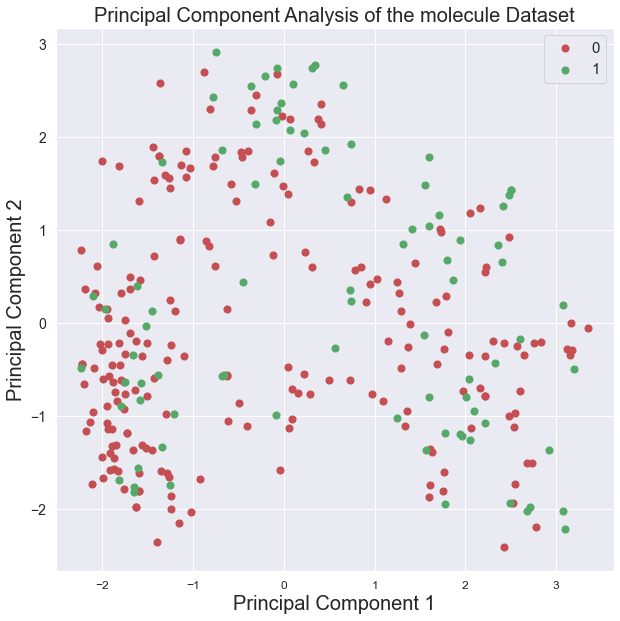

In [22]:
# Display scatter plot using the scatter_plot_pca function
scatter_plot_pca()

The scatter plot does not show a well defined separation between the 2 classes.

## Chapter 2 : Modelling <a class="anchor" id="mod"></a>

### Section 2.1 Predictive model building <a class="anchor" id=" train"></a>

### Section 2.1.1 Morgan Fingerprint function and Custom transformer class <a class="anchor" id="morgan"></a>

We want to create a **transformer class** (to be able to modify easily the parameters of the **MorganFingerprint function**) that will work with Scikit-Learn functionalities (like **pipelines**) as we will need them.

For this task we will create a class and implement three methods: 
    - fit() (returns self)
    - transform()
    - and fit_transform()
    
By adding TransformerMixin as a base class we will get the fit_transform method. 

We use **MorganFingerprint** to detect **similarities between molecules.** This function is applied to a molecule and generate a bit vector (binary) of varying size. This function takes 2 parameters in account :
- **nBits** representing the output vector size it can be 512, 1024, 2048 or 4096 long.
- **Radius** which is an integer representing the neighborhood taken into account for each atom. It can also be seen as the size of the fragment taken for comparison.

We may consider modifying the **nBits** and **Radius** size but how to modify these **parameters** and the **hyperparameters** at the same time properly ?
To reach this goal our **custom transformer class** will help us as we will see further.

<div>
<img src="https://ars.els-cdn.com/content/image/1-s2.0-S1046202314002631-gr1.sml" width="200"/>
</div>

**Source :** https://ars.els-cdn.com/content/image/1-s2.0-S1046202314002631-gr1.sml

In [23]:
# Instantiation of the class Morgan which heritates from BaseEstimator and TransformerMixin classes (from sklearn)
class Morgan(BaseEstimator, TransformerMixin):
    """Takes parameters values (input_morgan_fingerprint_size and input_radius) 
       as input returns a numpy array of the molecules features 
       """
    def __init__(self, input_morgan_fingerprint_size = 512, input_radius = 1): # no *args or **kargs
        # Parameters to change the features generated (set initially at 512 for fingerprint_size and 1 for radius)
        self.input_morgan_fingerprint_size = input_morgan_fingerprint_size
        self.input_radius = input_radius
    
    def fit(self, X, y = None):
        return self # nothing else to do
    
    def transform(self, X, y = None):
        # Generate the MorganFingerprint features and returns a numpy array vector
        Vec = [AllChem.GetMorganFingerprintAsBitVect(x, self.input_radius,self.input_morgan_fingerprint_size) for x in X]
        return np.array(Vec)

Example of usage of the **custom class (Morgan)**

In [24]:
# Instantiate an instance of the class Morgan to try our class
X_train = [Chem.MolFromSmiles(x) for x in train.SMILES] # Generate molecules from SMILES data (using the train dataset)
Morgan(512, 2).transform(X_train)

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

The class works well and returns as expected a binary matrix of size 512   

### Section 2.1.2 Data processing pipeline <a class="anchor" id="pipeline"></a>

**Parameters** are learnt from the data (like the **coefficients** in **logistic or linear regression**), however some parameters are not they are called **hyperparameters** no analytical formula is available to compute the appropriate value.

Differents methods exist to find the appropriate set of hyperparameters we will use the **grid search method.**
Grid search let use to test **several combinations of hyperparameters** defined by the user. One drawback of this method is that it can be very quickly **computationally expensive.** 

We may consider other methods especially when the dataset is big.

ADASYN is a method of oversampling (derived from the SMOTE method) used to generate other data points in the Minority class (in our case Activity=1). A new data point is created using k nearest neighbors. 

In [25]:
# Instanciate an adasyn object to prepare the resampling
adasyn = ADASYN(random_state = 88)

Before splitting our dataset into train and test we have to be sure that the **proportion of active molecule** will be same after the splitting. For that we use the **"stratify"** option present in the **train_test_split** function.

In [26]:
# Split the "train dataframe" into a train and a test dataset, while stratifying with the target variable and a random_state to reproduce the result
x_train, x_test, y_train, y_test = train_test_split(train['SMILES'], train['Activity'], test_size = 0.2, stratify = train['Activity'], random_state = 2020)

<AxesSubplot:title={'center':'Frequency of the distribution of the target variable (Activity)'}>

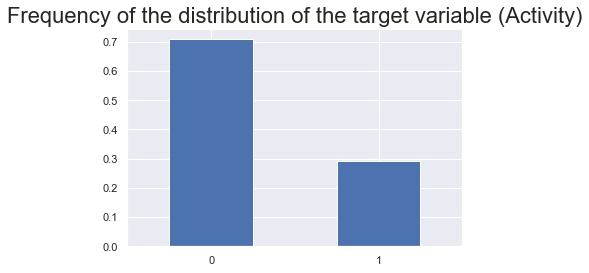

In [27]:
#As a sanity check we confirm the proportion of Active molecules is same in both set :
# Check frequency of the target variable in the train dataset (after split)
plot_cat(pd.DataFrame(y_train),'Activity')

<AxesSubplot:title={'center':'Frequency of the distribution of the target variable (Activity)'}>

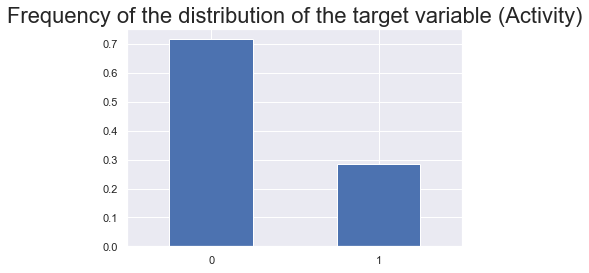

In [28]:
# Plot the frequency of the target variable in the test set (after split)
plot_cat(pd.DataFrame(y_test),'Activity')

We confirmed the **proportion of the target variable in same** between the **train** and the **test** set (after splitting) 

In [29]:
# Extract molecule information (transformation into a Rdkit object)
x_train = [Chem.MolFromSmiles(x) for x in x_train]
x_test = [Chem.MolFromSmiles(x) for x in x_test]

### Machine Learning model choice
Several classification machine learning models will be assessed :
- Logistic regression
- Decision Tree
- Random Forest
- XGBoost
- Support Vector Machine

### Metric choice

The **goal of this work is to predict the "activity" of a set of molecules**. This can represent the activation of a protein receptor for example.
So our problem is a classification problematic. 

The **main metric used for classification is the accuracy.** However our dataset is a bit **unbalanced** indeed the proportion of unactive molecule is ~
so we have to consider use another metric like the **AUC.**

We use the AUC to make a plot showing the **True Positive Rate (Sensitivity)** against the **False Positive Rate (1-Specificity).**
The more the curve is near the upper-left corner the more the classifier is good, a diagonal indicates a **"no skill classifier"** (predict a random or a constant class every time).

<div>
<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/10/Depiction-of-a-ROC-Curve.jpg" width="300"/>
</div>

In [30]:
# Instanciate a PCA object keeping 90% of the explained variance of the dataset
pca = PCA(n_components = 0.9)

**Pipeline are classes implemented in sklearn** that are very useful. They are used to **chain differents transformation** of the data.
These steps can be **cross-validated together** using a **specific metric** implemented in sklearn (such as accuracy or roc_auc_score).

In [31]:
# Build our custom pipelines for 5 machine learning algorithm : Logistic Regression, Decision Tree, Random Forest,Extreme Gradient Boosting, Support Vector Machine

pipe_lr = Pipeline([('fingerprint', Morgan()),
                    ('sampling', adasyn),
                   (('pca', pca)),
                ('clf', LogisticRegression(random_state=42))])

pipe_dt = Pipeline([('fingerprint', Morgan()),
                    ('sampling', adasyn),
                   (('pca', pca)),
                 ('clf', DecisionTreeClassifier(random_state=42))])

pipe_rf = Pipeline([('fingerprint', Morgan()),
                    ('sampling', adasyn),
                   (('pca', pca)),
            ('clf', RandomForestClassifier(random_state=42))])


pipe_svm = Pipeline([('fingerprint', Morgan()),
                     ('sampling', adasyn),
                   (('pca', pca)),
            ('clf', svm.SVC(random_state=42))])

pipe_xgb = Pipeline([('fingerprint', Morgan()),
                     ('sampling', adasyn),
                   (('pca', pca)),
            ('clf', XGBClassifier(learning_rate = 0.02, n_estimators = 600, objective='binary:logistic',
                    silent = True, nthread = -1,random_state = 42))])

### Section 2.1.3 Hyperparameters optimization <a class="anchor" id="hyper"></a>

In [32]:
# Set grid search params
param_range = [i for i in range(2,12,2)]
param_range_fl = [1.0, 0.5]
param_nBits = [512, 1024, 2048, 4096]
param_radius = [1, 2, 3, 4, 5, 6]

# Parameters that will be assessed by grid search (specific to Logistic Regression)
grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear'],
        'fingerprint__input_morgan_fingerprint_size' : param_nBits,
        'fingerprint__input_radius' : param_radius}] 

# Parameters that will be assessed by grid search (specific to Decision Tree)
grid_params_dt = [{'clf__criterion': ['gini'],
        'clf__max_depth': param_range,
        'fingerprint__input_morgan_fingerprint_size' : param_nBits,
        'fingerprint__input_radius' : param_radius}]

# Parameters that will be assessed by grid search (specific to Random Forest)
grid_params_rf = [{'clf__criterion': ['gini'],
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range,
        'fingerprint__input_morgan_fingerprint_size' : param_nBits,
        'fingerprint__input_radius' : param_radius}]

# Parameters that will be assessed by grid search (specific to XGBoost)
grid_params_xgb = [{'clf__min_child_weight': [1, 5, 10],
        'clf__gamma': [0.5, 1, 1.5, 2],
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.6, 0.8, 1.0],
        'clf__max_depth': [3, 4, 5],
        'fingerprint__input_morgan_fingerprint_size' : param_nBits,
        'fingerprint__input_radius' : param_radius}]

# Parameters that will be assessed by grid search (specific to Support Vector Machine)
grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
        'clf__C': param_range,
        'fingerprint__input_morgan_fingerprint_size' : param_nBits,
        'fingerprint__input_radius' : param_radius}]


In [33]:
# Construct grid searches by algorithms
jobs = -1

# Object containing pipeline and specific parameters for grid search 
# as well as the metric and CV specifications for Logistic Regression
LR = GridSearchCV(estimator = pipe_lr,
            param_grid = grid_params_lr,
            scoring='roc_auc',
            cv=5) 

# Object containing pipeline and specific parameters for grid search 
# as well as the metric and CV specifications for Decision Tree
DT = GridSearchCV(estimator = pipe_dt,
            param_grid = grid_params_dt,
            scoring = 'roc_auc',
            cv = 5, 
            n_jobs = jobs)

# Object containing pipeline and specific parameters for grid search 
# as well as the metric and CV specifications for Random Forest
RF = GridSearchCV(estimator = pipe_rf,
            param_grid = grid_params_rf,
            scoring = 'roc_auc',
            cv = 5, 
            n_jobs = jobs)

# Object containing pipeline and specific parameters for grid search 
# as well as the metric and CV specifications for XGBoost
XGB = GridSearchCV(estimator = pipe_xgb,
            param_grid = grid_params_xgb,
            scoring = 'roc_auc',
            cv = 5, 
            n_jobs = jobs)

# Object containing pipeline and specific parameters for grid search 
# as well as the metric and CV specifications for Support Vector Machine
SVM = GridSearchCV(estimator = pipe_svm,
            param_grid = grid_params_svm,
            scoring = 'roc_auc',
            cv = 5,
            n_jobs = jobs)

In [34]:
# List of pipelines for iterating through each of them
grids = [LR,DT,RF,XGB,SVM]

# Creating a dict for our reference
grid_dict = {0: 'Logistic Regression', 
             1: 'Decision Tree',
             2: 'Random Forest',
             3: 'XGBoost',
             4: 'Support Vector Machine'}

In [35]:
# Fit the grid search objects
print('Performing model optimizations...')
best_roc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    gs.fit(x_train, y_train)
    print('Best params are : %s' % gs.best_params_)
    # Best training data roc score
    print('Best training roc_auc_score: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(x_test)
    # Test data roc score of model with best params
    print('Test set roc_auc score for best params: %.3f ' % roc_auc_score(y_test, y_pred))
    # Track best (highest test roc auc) model
    if roc_auc_score(y_test, y_pred) > best_roc:
        best_roc = roc_auc_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set roc auc: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'best_grid_search_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: Logistic Regression
Best params are : {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'fingerprint__input_morgan_fingerprint_size': 4096, 'fingerprint__input_radius': 3}
Best training roc_auc_score: 0.791
Test set roc_auc score for best params: 0.719 

Estimator: Decision Tree
Best params are : {'clf__criterion': 'gini', 'clf__max_depth': 4, 'fingerprint__input_morgan_fingerprint_size': 2048, 'fingerprint__input_radius': 5}
Best training roc_auc_score: 0.720
Test set roc_auc score for best params: 0.626 

Estimator: Random Forest
Best params are : {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_split': 2, 'fingerprint__input_morgan_fingerprint_size': 1024, 'fingerprint__input_radius': 4}
Best training roc_auc_score: 0.782
Test set roc_auc score for best params: 0.707 

Estimator: XGBoost
[01:45:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { si

In [36]:
# Use the best parameters to predict the Activity of the x_test dataset
pred = best_gs.predict(x_test)

In [37]:
# Check y_test shape
y_test.shape

(60,)

In [38]:
# Build a confusion matrix using the predicted and true y
conf_matrix = confusion_matrix(y_test, pred)

In [39]:
def nice_conf_matrix(confusion_matrix):
    """From a confusion matrix object display a nicer confusion matrix with labels"""
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
    #group_percentages = ["{0:.2%}".format(value) for value in
    #                     conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    plt.title("Confusion matrix using Logistic Regression after Grid Search", fontsize = 18);
    return sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')

<AxesSubplot:title={'center':'Confusion matrix using Logistic Regression after Grid Search'}>

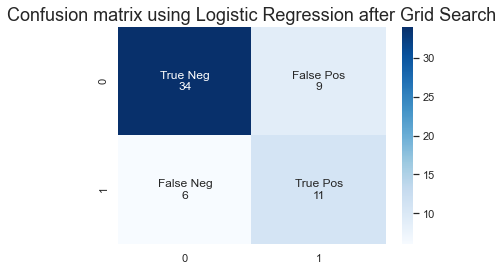

In [40]:
# Display the confusion matrix with labels (True Neg, True Pos, False Pos, False Neg)
nice_conf_matrix(conf_matrix)

This **Confusion Matrix** shows the performance of the Logistic Regression on the test set (of size 60). That is why the confusion matrix shows the details : **True Positive, True Negative, False Negative and False Positive** on the **test** set. The **accuracy** is good (**75% on the test set**) but it is not sufficient to evaluate the quality of a model (especially when the dataset is **unbalanced**) that is why we checked the **AUC** and the **ROC curve.**

### Create a ROC curve of the selected model

In [41]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = best_gs.predict_proba(x_test)
# Keep 2nd column
lr_probs = lr_probs[:, 1]

In [42]:
# Create a function to display the roc score
def display_roc_score(model,x_test,y_test):
    """Print the ROC score of a specified model using x_test and y_test"""
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = best_gs.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('Baseline: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))

In [43]:
# Display the roc score
display_roc_score(best_gs,x_test,y_test)

Baseline: ROC AUC=0.500
Logistic: ROC AUC=0.804


In [44]:
# Create a roc_score curve
def plot_roc_curve():
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    plt.title("ROC curve using Logistic Regression model after Grid Search vs Baseline model", fontsize = 18);
    # show the plot
    plt.show()

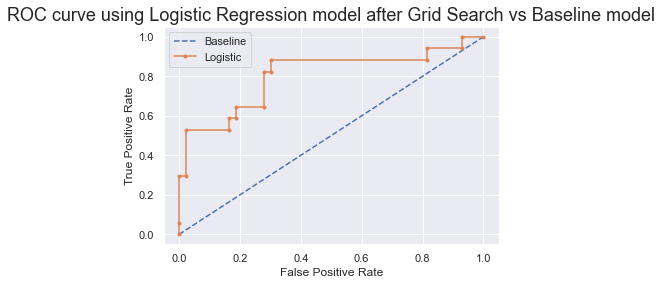

In [45]:
# Display the roc curve of the best model selected by GridSearch
plot_roc_curve()

### Suggestions to improve the model
- Try other **descriptors** of the molecule and find **similarities between molecules** leading to a **trigger of an activity** (informations about the **nature of the Activity variable** can also be useful).
- Test other **Machine Learning algorithms**
- Try other methods to find the **best hyperparameters** like **RandomSearch** or **BayesianSearch.**
- Change the **PCA parameters** as well as the **Adasyn parameters**, we can also test the **Smote algorithm**
- Assess other metrics F1 score for example

### Section 2.2 Activity prediction on the test set <a class="anchor" id="test"></a>

In [46]:
# Extract rdkit object from molecules informations (SMILES)
test_mol = [Chem.MolFromSmiles(x) for x in test['SMILES']]

In [47]:
# Build a function to save the submission file
def save_submission(test_mol,test,filename):
    """Save our submission and print a message with the output filename
    Keyword arguments:
    test_mol -- a list containing the molecules of the test dataset
    test -- the Python dataframe containing SMILES informations (and no informations on the target variable)
    filename -- The name and the format we choose to give to our submission
    """
    predictions = best_gs.predict(test_mol)
    submission = pd.DataFrame({'SMILES':test['SMILES'],'Activity':predictions})
    filename = 'test_set_data.csv'
    submission.to_csv(filename,index=False)
    print('Saved file: ' + filename)

In [48]:
# Call the function save_submission
save_submission(test_mol,test,'test_set_data.csv')

Saved file: test_set_data.csv
